<h1> <center>                    Projeto Final CDD- Prever a nota de um filme no IMDB </center> </h1>

<b>
    <center>André Vital Tavernaro</center>
</b>
<b>
    <center>Daniel Zelv Freund</center>
</b>
<b>
    <center>Guilherme Batista</center>
</b>

***

1. Import de Bibliotecas
2. Leitura dos dados
3. Criação das funções utilizadas na análise dos dados

In [534]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm, probplot
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import json
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [535]:
### Função utilizada para fazer a regressão com constante adicionada
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [536]:
def verificador_nulo(dataframe):
    i = 0
    for e in dataframe.columns.tolist():
        valores_nulos = len(dataframe[dataframe[e]==0])
        if valores_nulos > 0:
            print('{0} {1}' .format(valores_nulos, e))
            i += 1
    if i == 0:
        print('Nenhum valor nulo encontrado!')

In [537]:
dados_raw = pd.read_csv("tmdb_5000_movies.csv")

In [538]:
dados_raw.tail(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""id"": 3958}...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-10-13,0,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,"Signed, Sealed, Delivered",7.0,6
4801,0,[],http://shanghaicalling.com/,126186,[],en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-05-03,0,98.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A New Yorker in Shanghai,Shanghai Calling,5.7,7
4802,0,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,25975,"[{""id"": 1523, ""name"": ""obsession""}, {""id"": 224...",en,My Date with Drew,Ever since the second grade when he first saw ...,1.929883,"[{""name"": ""rusty bear entertainment"", ""id"": 87...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2005-08-05,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,My Date with Drew,6.3,16


In [539]:
print(dados_raw.columns.tolist())

['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count']


### Análise de dados

- Junção dos dados para análise

In [540]:
df_analise = dados_raw[["title","runtime","budget","revenue", "vote_average", 
                            "vote_count", "popularity","genres",'release_date']].copy()

In [541]:
df_analise['year'] , df_analise['month'] , df_analise['day'] = df_analise['release_date'].str.split('-',2).str
df_analise['year'] = pd.to_numeric(df_analise['year'])
df_analise['month'] = pd.to_numeric(df_analise['month'])
df_analise['day']  = pd.to_numeric(df_analise['day'] )

- Remoção de valores nulos

In [542]:
verificador_nulo(df_analise)

35 runtime
1037 budget
1427 revenue
63 vote_average
62 vote_count
1 popularity


In [543]:
df_analise.drop(df_analise[df_analise["budget"]==0].index,inplace=True)
df_analise.drop(df_analise[df_analise["revenue"]==0].index,inplace=True)

In [544]:
verificador_nulo(df_analise)

2 vote_average
2 vote_count


- Substituição de valores nulos com suas medianas (average e count)

In [545]:
df_analise.vote_average.replace(0, df_analise.vote_average.median(), inplace=True)
df_analise.vote_count.replace(0, df_analise.vote_count.median(), inplace=True)

- Separação de generos ao dataset

In [546]:
genres = set()
for x in df_analise['genres']:
    for g in json.loads(x):
        genres.add(g["name"])

In [547]:
def extrai_generos(item):
    generos = {'c_' + x: 0 for x in ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 
                              'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 
                              'History', 'Horror', 'Music', 'Mystery', 'Romance', 
                              'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']}
    for g in json.loads(item):
        generos['c_' + g['name']] += 1
    return generos

dados_generos = pd.DataFrame(list(df_analise['genres'].apply(extrai_generos).values))
df = df_analise.join(dados_generos)
df.set_index("title", inplace=True)
df.drop(columns= "genres", inplace=True)
df.drop(columns= "release_date", inplace=True)

In [548]:
df.tail(3)

,runtime,budget,revenue,vote_average,vote_count,popularity,year,month,day,c_Action,...,c_History,c_Horror,c_Music,c_Mystery,c_Romance,c_Science Fiction,c_TV Movie,c_Thriller,c_War,c_Western
title,,,,,,,,,,,,,,,,,,,,,
Cure,111.0,20000,99000,7.4,63,0.212443,1997.0,11.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Primer,77.0,7000,424760,6.9,658,23.307949,2004.0,10.0,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
El Mariachi,81.0,220000,2040920,6.6,238,14.269792,1992.0,9.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [549]:
df.drop_duplicates(inplace=True)

__Analíse gráfica__

- Heatmap

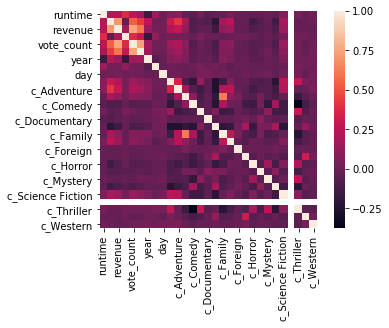

In [550]:
sns.heatmap(df.corr(), vmax=1, square=True);

- BOXPLOT

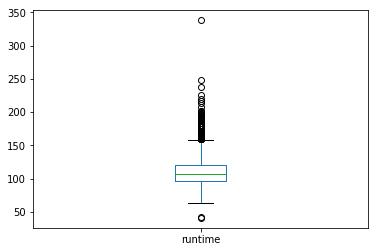

In [551]:
df['runtime'].plot.box();

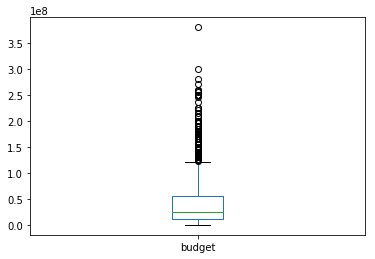

In [552]:
df['budget'].plot.box();

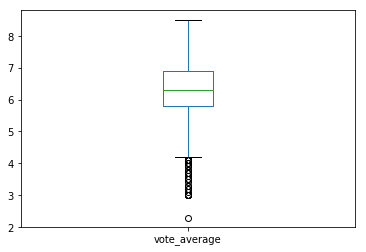

In [553]:
df['vote_average'].plot.box();

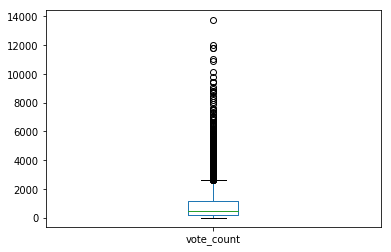

In [554]:
df['vote_count'].plot.box();

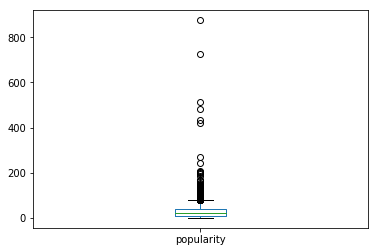

In [555]:
df['popularity'].plot.box();

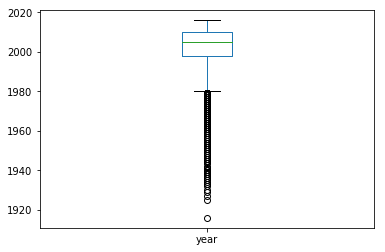

In [556]:
df['year'].plot.box();

- Análise dos maiores valores de budget

In [557]:
df.nlargest(10, 'budget')

,runtime,budget,revenue,vote_average,vote_count,popularity,year,month,day,c_Action,...,c_History,c_Horror,c_Music,c_Mystery,c_Romance,c_Science Fiction,c_TV Movie,c_Thriller,c_War,c_Western
title,,,,,,,,,,,,,,,,,,,,,
Pirates of the Caribbean: On Stranger Tides,136.0,380000000,1045713802,6.4,4948,135.413856,2011.0,5.0,14.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pirates of the Caribbean: At World's End,169.0,300000000,961000000,6.9,4500,139.082615,2007.0,5.0,19.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Avengers: Age of Ultron,141.0,280000000,1405403694,7.3,6767,134.279229,2015.0,4.0,22.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Superman Returns,154.0,270000000,391081192,5.4,1400,57.925623,2006.0,6.0,28.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
John Carter,132.0,260000000,284139100,6.1,2124,43.926995,2012.0,3.0,7.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Tangled,100.0,260000000,591794936,7.4,3330,48.681969,2010.0,11.0,24.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spider-Man 3,139.0,258000000,890871626,5.9,3576,115.699814,2007.0,5.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Lone Ranger,149.0,255000000,89289910,5.9,2311,49.046956,2013.0,7.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
The Dark Knight Rises,165.0,250000000,1084939099,7.6,9106,112.312950,2012.0,7.0,16.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


- Remoção de outliers de budget

In [558]:
df.drop(df[df['budget'] > df['budget'].quantile(q=0.98)].index,inplace=True)

In [559]:
df.dropna(inplace=True)

### Cálculo e acuracia

**Dicionário de dados:**


Variável | Descrição
:---:|---:
title | Título do filme
runtime | Tempo de filme
budget | Orçamento
revenue | Receita
vote_average | Média dos votos
vote_count | Número de votos das pessoas
popularity | Popularidade
genres | Os diferentes gêneros de filme
c_GENERO | 0: não pertence; 1: pertence (gênero)
ano | ano em que o filme foi lançado
mês | mês em que o filme foi lançado
dia | dia em que o filme foi lançado

## Com a ajuda do comando Describe, poderemos analisar fatores importantes do Dataframe


 

In [560]:
df.describe()

,runtime,budget,revenue,vote_average,vote_count,popularity,year,month,day,c_Action,...,c_History,c_Horror,c_Music,c_Mystery,c_Romance,c_Science Fiction,c_TV Movie,c_Thriller,c_War,c_Western
count,2507.000000,2.507000e+03,2.507000e+03,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,...,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.0,2507.000000,2507.000000,2507.000000
mean,111.659354,4.573431e+07,1.297682e+08,6.247028,1024.542082,30.710464,2003.580375,7.040287,15.459912,0.295174,...,0.045074,0.096131,0.031911,0.086957,0.168728,0.136418,0.0,0.302353,0.037894,0.014759
std,20.571029,3.649780e+07,1.624834e+08,0.846505,1365.467922,37.728261,9.402979,3.393749,8.403404,0.456212,...,0.207507,0.294829,0.175797,0.281828,0.374586,0.343300,0.0,0.459369,0.190978,0.120610
min,63.000000,1.000000e+01,1.100000e+01,2.300000,2.000000,0.034259,1927.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,97.000000,1.900000e+07,2.918877e+07,5.700000,224.500000,12.433340,1999.000000,4.000000,9.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,108.000000,3.500000e+07,7.318072e+07,6.300000,537.000000,22.769108,2005.000000,7.000000,15.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,122.000000,6.000000e+07,1.628923e+08,6.800000,1252.000000,38.811637,2010.000000,10.000000,22.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000
max,338.000000,1.750000e+08,1.513529e+09,8.500000,13752.000000,875.581305,2016.000000,12.000000,31.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


## Separação das  variáveis

Obtendo as variáveis resposta e preditora:

-Variável resposta (Y) , ou seja , as notas do site IMDB

-Variável preditora (X) , ou seja , todas as colunas que serão usadas para prever as notas dos filmes

In [561]:
Y = df[ "vote_average"]

In [562]:
X = df[["runtime","budget","revenue","vote_count", "popularity","c_Action", "c_Adventure","c_Animation","c_Comedy","c_History",
        "c_Horror","c_Music","c_Mystery","c_Romance","c_Science Fiction","c_TV Movie","c_Thriller","c_War","c_Western","month","year","day"]]

### Regressão

In [563]:
results = regress(X,Y)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     79.87
Date:                Tue, 13 Nov 2018   Prob (F-statistic):          1.90e-259
Time:                        23:37:37   Log-Likelihood:                -2492.4
No. Observations:                2507   AIC:                             5029.
Df Residuals:                    2485   BIC:                             5157.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                18.6573      3.025      6.168      0.000      12.726      24.589
runtime               0.0139      0.001     20.183      0.000       0.013       0.015
budget            -6.833e-09      5e-10    -13.654      0.000   -7.81e-09   -5.85e-09
revenue            1.322e-10   1.36e-10      0.974      0.330   -1.34e-10    3.98e-10
vote_count            0.0003   1.68e-05     17.179      0.000       0.000       0.000
popularity            0.0006      0.001      1.202      0.230      -0.000       0.002
c_Action              0.0418      0.035      1.209      0.227      -0.026       0.110
c_Adventure           0.0188      0.037      0.502      0.616      -0.055       0.092
c_Animation           0.1081      0.059      1.842      0.066      -0.007       0.223
c_Comedy              0.0203      0.031      0.645      0.519      -0.041       0.082
c_History             0.0937      0.068      1.371      0.171      -0.040       0.228
c_Horror             -0.0562      0.048     -1.180      0.238      -0.150       0.037
c_Music              -0.1572      0.076     -2.067      0.039      -0.306      -0.008
c_Mystery             0.0241      0.050      0.486      0.627      -0.073       0.121
c_Romance            -0.0638      0.038     -1.688      0.092      -0.138       0.010
c_Science Fiction     0.0031      0.041      0.075      0.940      -0.077       0.083
c_TV Movie        -6.372e-16   1.15e-16     -5.545      0.000   -8.63e-16   -4.12e-16
c_Thriller           -0.0186      0.034     -0.542      0.588      -0.086       0.049
c_War                 0.0744      0.073      1.013      0.311      -0.070       0.218
c_Western            -0.1104      0.110     -1.003      0.316      -0.326       0.106
month                 0.0225      0.004      5.724      0.000       0.015       0.030
year                 -0.0070      0.002     -4.694      0.000      -0.010      -0.004
day                  -0.0020      0.002     -1.246      0.213      -0.005       0.001
==============================================================================
Omnibus:                      235.306   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              410.043
Skew:                          -0.654   Prob(JB):                     9.13e-90
Kurtosis:                       4.488   Cond. No.                     2.47e+25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.86e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Criação do novo dataframe com variáveis releventes

#### Adotamos um ALFA de 5%, então só vamos usar na análise as variáveis  que possuem um P>T menor que o ALFA 

In [564]:
X = df[["runtime", "budget", "revenue", "vote_count", "popularity", "month", "year"]]

#### Separando o dataframe em teste e treinamento

In [565]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=RANDOM_SEED)

 #### Aplicando o modelo de regressão linear

In [566]:
model = LinearRegression()       #cria
model.fit(X_train, y_train)        #treina 
y_pred = model.predict(X_test)      #testa 

resultrl = 1 - mean_squared_error(y_test, y_pred) / np.var(y_test)
print('a margem de acerto do modelo de regressão linear é de {0}%'.format(resultrl.round(2)*100))

a margem de acerto do modelo de regressão linear é de 43.0%


#### Aplicando o modelo RandomForest

In [567]:
model = RandomForestRegressor()       #cria
model.fit(X_train, y_train)        #treina 
y_pred = model.predict(X_test)      #testa 

resultrf = 1 - mean_squared_error(y_test, y_pred) / np.var(y_test)
print('a margem de acerto do modelo RandomForest é de {0}%'.format(resultrf.round(2)*100))

a margem de acerto do modelo RandomForest é de 49.0%


#### Aplicando o modelo Cross_Val_Score

In [568]:
import sklearn.model_selection 

lista_probs= sklearn.model_selection.cross_val_score(model,X,Y,cv=10)

lista_probs
media_1=np.mean(lista_probs)

print('a margem de acerto do modelo Cross_val_score é de {0}%'.format(media_1.round(2)*100))

a margem de acerto do modelo Cross_val_score é de 42.0%
